In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree

In [3]:
df = pd.read_csv('/Users/34633/kagglada/complex-master-learn-and-get-your-mark/train.csv', sep=',', encoding = 'latin1')
df.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks,FreePass
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0,True
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0,True
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0,False
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0,False
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0,False


In [4]:
df.columns.tolist()
#df.shape

['Id',
 'PreferedAlbum',
 'Vinyl',
 'AvgTime',
 'TicketInfo',
 'Opinion',
 'Concert',
 'Age',
 'VIP',
 'Food',
 'Drinks',
 'FreePass']

FreePass
True     5216
False    4900
Name: count, dtype: int64


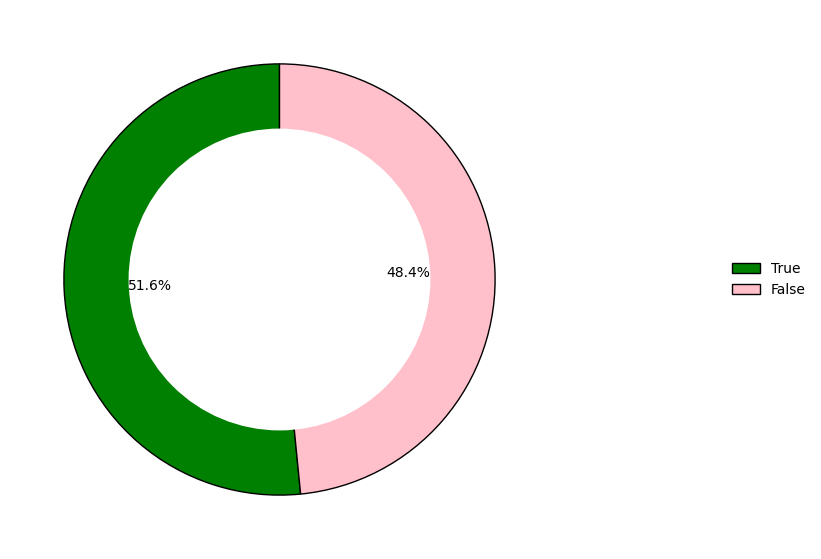

In [15]:
freepass = df['FreePass']
count_freepass = freepass.value_counts()
print(count_freepass)

labels = count_freepass.index.tolist()
colors = []
color_map = {
    True: 'green', 
    False: 'pink'
}
colors = [color_map.get(label, 'gray') for label in labels]


plt.figure(figsize=(7, 7))
plt.pie(count_freepass.values, autopct='%.1f%%', startangle=90, colors=colors,wedgeprops={'edgecolor': 'black', 'linewidth': 1})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(
    labels,
    loc="center right",
    bbox_to_anchor=(1, 0, 0.5, 1), frameon=False
)
plt.show()

In [33]:
df_sinfree = df.drop(columns=[df.columns[-1]])
df_sinfree.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0


In [36]:
X = df_sinfree.values
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=None)
clf.fit(X_train,y_train)
yhat = clf.predict(X_train)



ValueError: could not convert string to float: '01/4493'